In [21]:
import numpy as np
import pandas as pd
import joblib
import sys
import nltk
import os 
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
from nltk.corpus import wordnet as wn

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

sys.path.append('../')
from src.utilities.config_ import train_data_path, scrape_data_path, model_path

In [22]:
# Download stopwords if not already downloaded
# nltk.download()
stop_words = set(stopwords.words('english'))

In [23]:
# read csv
train_filename = "finance-dataset.csv"
df = pd.read_csv(os.path.join(train_data_path, train_filename))
df.head()

,label,title
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [24]:
# Step - a : Remove blank rows if any.
df['title'].dropna(inplace=True)

df['title'] = [entry.lower() for entry in df['title']]
df_tokenized = df.copy()
df_tokenized['tokenized_title'] = [word_tokenize(entry) for entry in df['title']]
df['title']= [word_tokenize(entry) for entry in df['title']]


tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(df['title']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'text_final'] = str(Final_words)
df

,label,title,text_final
0,neutral,"[according, to, gran, ,, the, company, has, no...","['accord', 'gran', 'company', 'plan', 'move', ..."
1,neutral,"[technopolis, plans, to, develop, in, stages, ...","['technopolis', 'plan', 'develop', 'stage', 'a..."
2,negative,"[the, international, electronic, industry, com...","['international', 'electronic', 'industry', 'c..."
3,positive,"[with, the, new, production, plant, the, compa...","['new', 'production', 'plant', 'company', 'wou..."
4,positive,"[according, to, the, company, 's, updated, str...","['accord', 'company', 'updated', 'strategy', '..."
...,...,...,...
4841,negative,"[london, marketwatch, --, share, prices, ended...","['london', 'marketwatch', 'share', 'price', 'e..."
4842,neutral,"[rinkuskiai, 's, beer, sales, fell, by, 6.5, p...","['rinkuskiai', 'beer', 'sale', 'fell', 'per', ..."
4843,negative,"[operating, profit, fell, to, eur, 35.4, mn, f...","['operating', 'profit', 'fell', 'eur', 'mn', '..."
4844,negative,"[net, sales, of, the, paper, segment, decrease...","['net', 'sale', 'paper', 'segment', 'decrease'..."


In [34]:
# split the data into features (X) and labels (y)
X = df['title']
y = df['label']

# Split the data into training and testing sets
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text_final'],df['label'],test_size=0.2)

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)


In [35]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(df['text_final'])


# Fit and transform the training data, and transform the testing data
Train_X_Tfidf = vectorizer.transform(Train_X)
Test_X_Tfidf = vectorizer.transform(Test_X)


In [36]:
# Define the parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM model
svm_model = SVC()

# Initialize Grid Search with cross-validation
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit Grid Search to the data
svm_grid_search.fit(Train_X_Tfidf, Train_Y)

# Best parameters and score
print("Best SVM parameters:", svm_grid_search.best_params_)
print("Best SVM score:", svm_grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.0s
[CV] END ....................C=0.1, gamma=scale

SVM Model after fine-tuning
Accuracy: 0.7525773195876289
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.41      0.53       138
           1       0.75      0.95      0.84       576
           2       0.75      0.50      0.60       256

    accuracy                           0.75       970
   macro avg       0.75      0.62      0.66       970
weighted avg       0.75      0.75      0.73       970



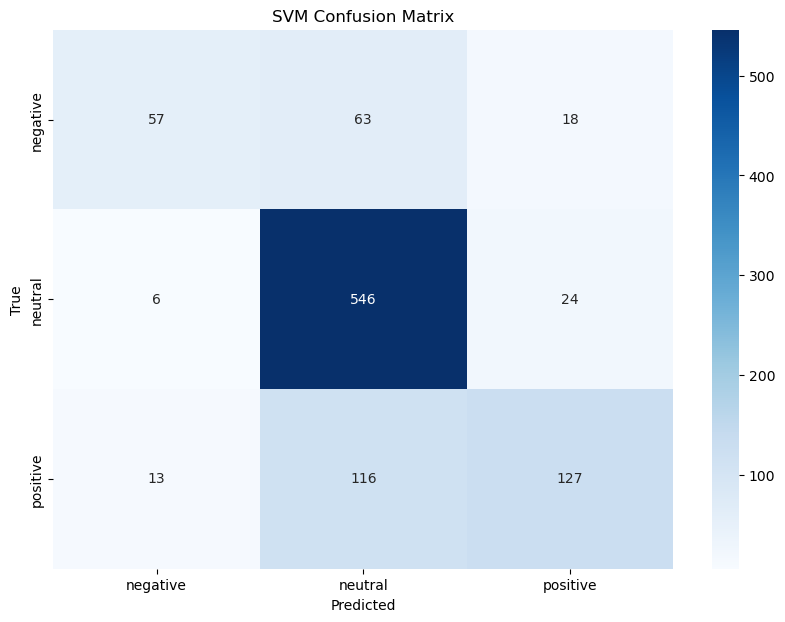

In [37]:
# Use the best estimator to make predictions
best_svm_model = svm_grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(Test_X_Tfidf)

# Evaluate the model
print("SVM Model after fine-tuning")
print("Accuracy:", accuracy_score(Test_Y, y_pred_svm))
print("Classification Report:")
print(classification_report(Test_Y, y_pred_svm))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(Test_Y, y_pred_svm, labels=[0, 1, 2])

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

In [38]:
# Define the parameter grid for Naive Bayes
nb_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 5, 10],
    'fit_prior': [True, False]
}

# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Initialize Grid Search with cross-validation
nb_grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit Grid Search to the data
nb_grid_search.fit(Train_X_Tfidf, Train_Y)

# Best parameters and score
print("Best Naive Bayes parameters:", nb_grid_search.best_params_)
print("Best Naive Bayes score:", nb_grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.0s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.0s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.0s
[CV] END ..........................alpha=0.1, fi

Naive Bayes Model after fine-tuning
Accuracy: 0.702061855670103
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52       138
           1       0.74      0.87      0.80       576
           2       0.58      0.47      0.52       256

    accuracy                           0.70       970
   macro avg       0.66      0.59      0.61       970
weighted avg       0.69      0.70      0.69       970



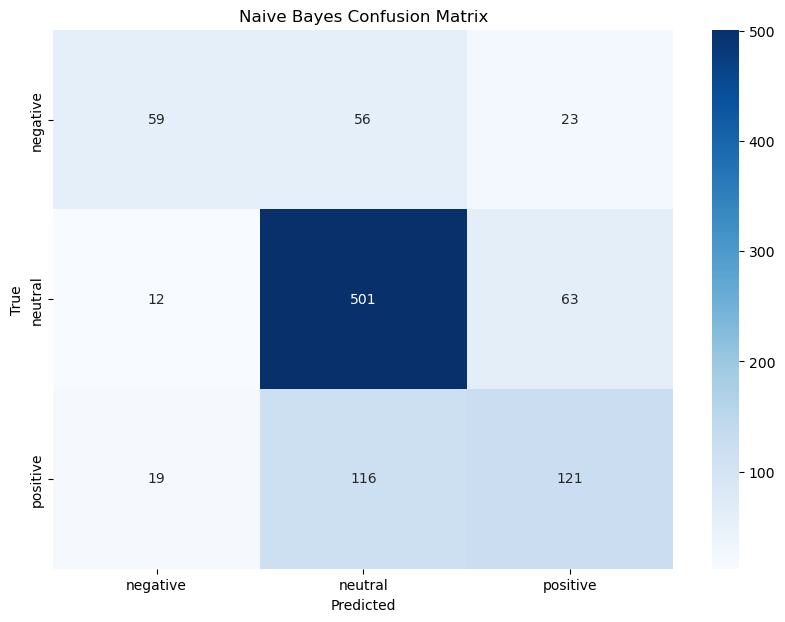

In [39]:
# Use the best estimator to make predictions
best_nb_model = nb_grid_search.best_estimator_
y_pred_nb = best_nb_model.predict(Test_X_Tfidf)

# Evaluate the model
print("Naive Bayes Model after fine-tuning")
print("Accuracy:", accuracy_score(Test_Y, y_pred_nb))
print("Classification Report:")
print(classification_report(Test_Y, y_pred_nb))

# Confusion Matrix
cm = confusion_matrix(Test_Y, y_pred_nb, labels=[0, 1, 2])

# Plot the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [40]:
# save svm model
svm_file = "svm_model.pkl"
joblib.dump(best_svm_model, os.path.join(model_path, svm_file))

# save naive bayes model
nb_file = "naive_bayes_model.pkl"
joblib.dump(best_nb_model, os.path.join(model_path, nb_file))

['/Users/shabrinashafura/Documents/Code/market-dashboard-ml/model/naive_bayes_model.pkl']

In [41]:
# Save the TF-IDF vectorizer
vectorizer_file = "tfidf_vectorizer.pkl"
joblib.dump(vectorizer, os.path.join(model_path, vectorizer_file))

['/Users/shabrinashafura/Documents/Code/market-dashboard-ml/model/tfidf_vectorizer.pkl']

In [42]:
# Load TFIDF
loaded_svm_model = joblib.load(os.path.join(model_path, svm_file))

# Load the saved TF-IDF vectorizer
vectorizer_file = "tfidf_vectorizer.pkl"
loaded_vectorizer = joblib.load(os.path.join(model_path, vectorizer_file))

In [52]:
# New text data to predict
new_texts = ["USD Drop"]

# Preprocess the new text data
new_texts_tfidf = loaded_vectorizer.transform(new_texts)

In [53]:
# Predict the labels for the new text data
predictions = loaded_svm_model.predict(new_texts_tfidf)

# Output the predictions
print(predictions)

[0]
